# Simple pricing comparison between quantum hardware vendors

```{post} 2025-05-25
:category: Hardware
```

Computing the cost of executing circuits between different quantum hardware modalities is quite challenging.  Namely, the pricing structures are markedly different, there are lots of special conditions that can apply, and the same hardware can be prcied differently depending on the cloud provider one goes through.  

Here I do a very simple yet effective price comparison between IBM, IonQ, and Quantinuum over a range of single- and two-qubit gate values.  The stark differences in pricing are readily apparent in this example.

## Frontmatter

Here we load the imports we need for this notebook. Here we will use the `RunningMan` library for executing circuits on IBM hardware.  If you want to reproduce the results here, you can grab this package using `pip install runningman`, or rewrite the notebook to use the standard IBM Runtime.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

from qiskit import *
import runningman as rm

%config InlineBackend.figure_format='retina'

In [2]:
provider = rm.RunningManProvider()

## Quantum hardware vendor pricing

Note that I am using only publically available pricing information, so I may not have all arrangements covered in the analysis.

### IBM Quantum

IBM Quantum [hardware execution pricing](https://www.ibm.com/quantum/pricing) is based on time.  In particular, the time here is the time that a given quantum system is locked to a specific user, and thus unavailable to others.  IBM Quantum rounds this time to the largest integer seconds; a value called "Runtime seconds".  At the time of writing there are three conversion factors used in converting Runtime seconds to US Dollars:

| Plan         | Description                        | Cost per Runtime second (USD) |
| :----------- | :--------------------------------: | ----------------------------: |
| Pay-go       | Pay for time as you use it         | 1.60                          |
| Flex         | Prepay for time in small units     | 1.20                          |
| Premium      | Usage contracts covering 1+ years  | 0.80                          |

Note that I am not including the "Open Plan" here, which gives an user 10 minutes of runtime per month.  Nor am I considering the pricing of whole-system access.  This kind of access is out of scope here.

Because IBM's pricing is based on time (rounded up to nearest second), it is near impossible to get an exact cost for executing a given circuit.  Qiskit will estiamte the execution time, and do a good job of it, but there is also idle-time between circuits and IO / classical overheads to deal with.  To get around these issues, below we will just execute circuits on hardware to get the true costs.

### IonQ

Unlike IBM, IonQ's quantum systems are available from multiple cloud providers, each with their own pricing structures.  IonQ has two families of system currently available: the 25-qubit Aria and 32-qubit Forte devices.  Each can have its own pricing numbers.

#### MS Azure

On MS Azure, [pricing](https://learn.microsoft.com/en-us/azure/quantum/pricing) is computed by counting the number of single- and two-qubit gates in the circuit.  These are then multiplied by the number of shots (number of times the circuit is executed) and a numerical coefficient that converts the gates to dollars.  In addition, there is a constant charge per job sent to the hardware.  Because only a single circuit can be sent per job, this is just a flat-rate overhead for submitting a circuit.  Concretely, the formula is:

$$
\rm{AQT} = m + 0.000220*(N_{1Q}*\rm{shots}) + 0.000975*(N_{2Q}*\rm{shots})
$$

Here, $m$ can take on two possible values: $m=\$97.50$ if error-mitigation is turned on, which is default, otherwise $m=\$12.4166$.  MS Azure charges the same for both Aria and Forte systems.

#### Google Cloud

IonQ is also [avilable on Google Cloud](https://console.cloud.google.com/marketplace/product/ionq-public/ionq).  The Aria pricing follows the same pricing as MS Azure.  However, Google Cloud charges more for using the Forte system.  Namely when using Forte the constant job pricing values are $m=\$168.20$ with error mitigation on, and $m=\$25.79$ without.  In addition, the single- and two-qubit gate prices per shot are $0.0001645$ and $0.0011213$, respectively.

#### AWS Braket

Finally, IonQ can be accessed via AWS Braket.  Unlike both Azure and Google Cloud, [AWS charges a fixed price to execute a circuit](https://aws.amazon.com/braket/pricing/), regardless of the number of gates in the circuit.

| Device        | Cost per job (USD)                 | Cost per shot (USD)           |
| :------------ | :--------------------------------: | ----------------------------: |
| Aria          | 0.30                               | 0.03                          |
| Forte         | 0.30                               | 0.08                          |

So, for example, if one ran a circuit at $512$ shots on the Aria device the total price would be: $\$0.30 + \$0.03*512 = \$15.66$.

Note that AWS also offers a "Reservation Mode" price of 7,000 USD per hour, which equates to $1.94 per second.

### Quantinuum

Quantinuum systems are available through [MS Azure](https://learn.microsoft.com/en-us/azure/quantum/pricing), and like IonQ, are priced based on the number of operations within a circuit.  However, for Quantinuum, these operations also include qubit measurements.  The fomula is very similar to that of IonQ, and is given in terms of " H-system Quantum Credits" (HQC), previously known as Honeywell Quantum Credits since Honeywell makes the device:

$$
\rm{HQC} = 5 + \frac{\rm{shots}}{5000}*(N_{1Q} + 10 N_{2Q} + 5 N_{\rm{meas}})
$$

When using 20 qubits or less, the price per HQC is $\$12.50$. where as using up to 56 qubits, and thus running on their larger H2 system, the price is a dollar higher at $\$13.50$ per HQC.

## Price comparisons

### IonQ vs Quantinuum on MS Azure

The easiest comparison is looking at IonQ and Quantinuum on Azure.  Because both are priced by gate counts, and measurements for Quantinuum, this is a simple exercise.  Here we will use the lowest price options available on both systems.  Namely $m=\$12.4166$ for IonQ and $\$12.50$ per HQC for Quantinuum.  In addition, we will assume there are two measurements regrdless of the number of gates in the circuit.  Outside of this assumption, there is no need to specify the exact circuit to be executed.  We do however need to set a value for the number of times to sample the circuit (shots).  Here we use 512 shots as it is the Azure default value.

Now, since all quantum hardware is not equal we need to define the number of gates used in the comparison correctly.  According to [arXiv:2502.06471](https://doi.org/10.48550/arXiv.2502.06471), IonQ systems can execute at most 650 two-qubit gates, whereas Quantinuum can do no more than 18,375 and IBM approaches one million.  As such, we will limit ourselves to at most 650 two-qubit gates.  Likewise, we will restrict the number of sinlge-qubit gates to $3*650 = 1950$ gates.  The factor of three is just because when a generic two-qubit gate is decomposed one gets a handful of single-qubit gates.  Three seemed to be a reasonable guess for a value after a compiler is done with it.  Feel free to pick your own.

To perform the pricing, we create a two-dimensional grid of two-qubit and single-qubit values over which to compute the pricing:

In [3]:
x = np.arange(650+1)
y = np.arange(3*650+1)

In [4]:
X, Y = np.meshgrid(x, y)

We then use our pricing formulas to compute the cost of executing a circuit for each grid-point of values:

In [11]:
Z_ionq = 12.42+0.000975*(X*512)+0.00020*(Y*512)

In [12]:
Z_quantinuum = 12.50*(5+(10*X+Y+5*2)*512/5000)

All that is left now is to plot the results, which takes the most code, using a colormap normalized to the maximum Quantinuum value since, as we will see, it is the highest:

In [13]:
# Generate a custom colormap
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#e5f6ff",
                                                                "#bae6ff",
                                                                "#82cfff",
                                                                "#33b1ff",
                                                                "#1192e8",
                                                                "#0072c3",
                                                                "#00539a",
                                                                "#003a6d",
                                                                "#012749",
                                                                "#1c0f30",
                                                               ])

In [14]:
# format the contour labels
def fmt(x):
    return f"{int(x)}"

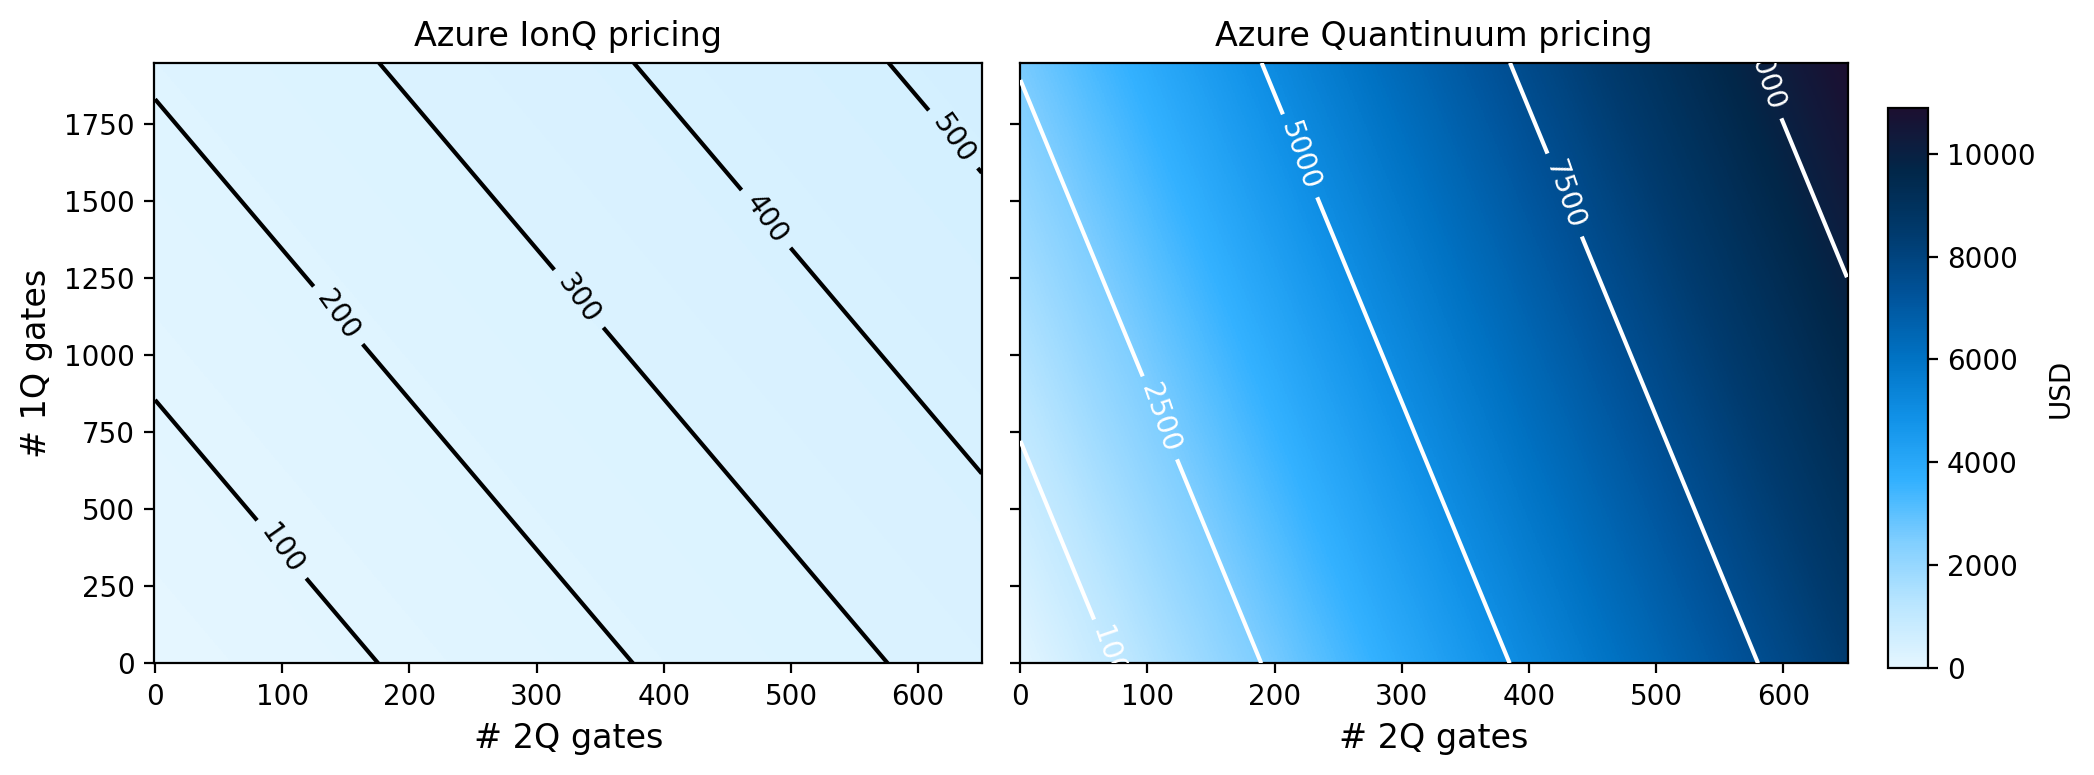

In [16]:
fig, axes = plt.subplots(1,2, figsize=(10,4), sharey=True)

res = axes[0].pcolormesh(X, Y, Z_ionq, cmap=cmap, vmin=0, vmax=Z_quantinuum.max())
cont = axes[0].contour(X, Y, Z_ionq, levels=[100, 200, 300, 400, 500], zorder=3, colors='k')
#plt.colorbar(res, label='USD');
axes[0].clabel(cont, cont.levels, fmt=fmt, fontsize=10)
axes[0].set_xlabel("# 2Q gates", fontsize=12)
axes[0].set_ylabel("# 1Q gates", fontsize=12)
axes[0].set_title('Azure IonQ pricing',fontsize=12)

res2 = axes[1].pcolormesh(X, Y, Z_quantinuum, cmap=cmap, vmin=0, vmax=Z_quantinuum.max())
cont2 = axes[1].contour(X, Y, Z_quantinuum, levels=[1000, 2500, 5000, 7500, 10000], zorder=3, colors='w')
#plt.colorbar(res2, label='USD');
axes[1].clabel(cont2, cont2.levels, fmt=fmt, fontsize=10);
axes[1].set_xlabel("# 2Q gates", fontsize=12)
#axes[1].set_ylabel("# 1Q gates", fontsize=12)
axes[1].set_title('Azure Quantinuum pricing',fontsize=12);

fig.tight_layout();
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb = fig.colorbar(res2, cax=cbar_ax)
cb.set_label(label='USD', size=10);

#### Conclusion

It is immediately obvious from the colormap that IonQ is much more price effective at executing circuits that Quantinuum is, especially as the number of gates in the circuit grows. We can get a quick sense of by how much by looking at the min, median, mean, and max of the ratio of costs:

In [24]:
cost_ratio = Z_quantinuum/Z_ionq

np.min(cost_ratio), np.median(cost_ratio), np.mean(cost_ratio), np.max(cost_ratio)

(np.float64(6.062801932367149),
 np.float64(19.97559198542805),
 np.float64(19.474905669149308),
 np.float64(24.919263876521228))

We see that, on average, Quantinuum is ~20x more expensive than IonQ.  It is obvious from the plot that this difference grows with the number of gates in the circuit.  However, even in the best case, Quantinuum is still 6x more than IonQ.  Note however, that our comparison says nothing about the quality of results when executing on the various platforms.

### IBM Quantum

Since IBM Quantum pricing is based on time, we will need to actually execute circuits to get the most accurate comparison.  Unlike before, we now need to specify a particular form of circuit to get the timing.  Here we will assume a worst case scenario where all gates are confined to a single-pair of qubits.  That is to say, we will purposely construct a circuit such that its depth / duration is as large as possible; the worst thing to do when billing based on time.

To begin, we divide the search space into smaller chunks :

In [5]:
x_steps = np.arange(0, 650+21, 20)
y_steps = np.arange(0, 3*650+61, 60)

In [6]:
X_steps, Y_steps = np.meshgrid(x_steps, y_steps)

We then select a target backend to use, and execute a circuit for each point in the grid, making sure to record the `mod_id` so that we can retrieve the results later.  In total, this should submit 1156 jobs to the device.

In [3]:
backend = provider.backend('ibm_aachen')

In [124]:
batch = backend.set_mode('batch', overwrite=True)
print(batch)
jobs = []
for ii in range(X_steps.shape[0]):
    for jj in range(X_steps.shape[1]):
        qc = QuantumCircuit(2)
        for _ in range(X_steps[ii][jj]):
            qc.cz(0,1)
            qc.barrier()
        for _ in range(Y_steps[ii][jj]//2):
            qc.x([0,1])
            qc.barrier()
        if Y_steps[ii][jj] % 2:
            qc.x([0])
        qc.measure_all()
        ops = qc.count_ops()
        assert ops.get('cz', 0) == X_steps[ii][jj]
        assert ops.get('x', 0) == Y_steps[ii][jj]
        job = backend.run(qc, shots=512)
        jobs.append(job)
backend.close_mode()

<RunningManMode('batch', mode_id='d0f29p6fbx30008vt4kg'>


Having run all the jobs on chip, we can retrive all the jobs by loading the mode (Batch in this case) using the `mode_id` we printed out earlier:

In [17]:
mode = provider.mode_from_id('d0f29p6fbx30008vt4kg')

Because there are three different pricing options available for IBM Quantum, we follow the same procedure we did before and pick the lowest cost option.  That is to say we will use the $\$0.80$ per Runtime second cost for the Premium plan.

In [23]:
Z_ibm = np.zeros_like(X_steps, dtype=float)
counter = 0
prefactor = 0.8 # cost conversion for Premium plan users
for ii in range(X_steps.shape[0]):
    for jj in range(X_steps.shape[1]):
        runtime = mode.jobs[counter].metrics()['usage']['seconds']
        Z_ibm[ii][jj] = prefactor * runtime
        counter += 1

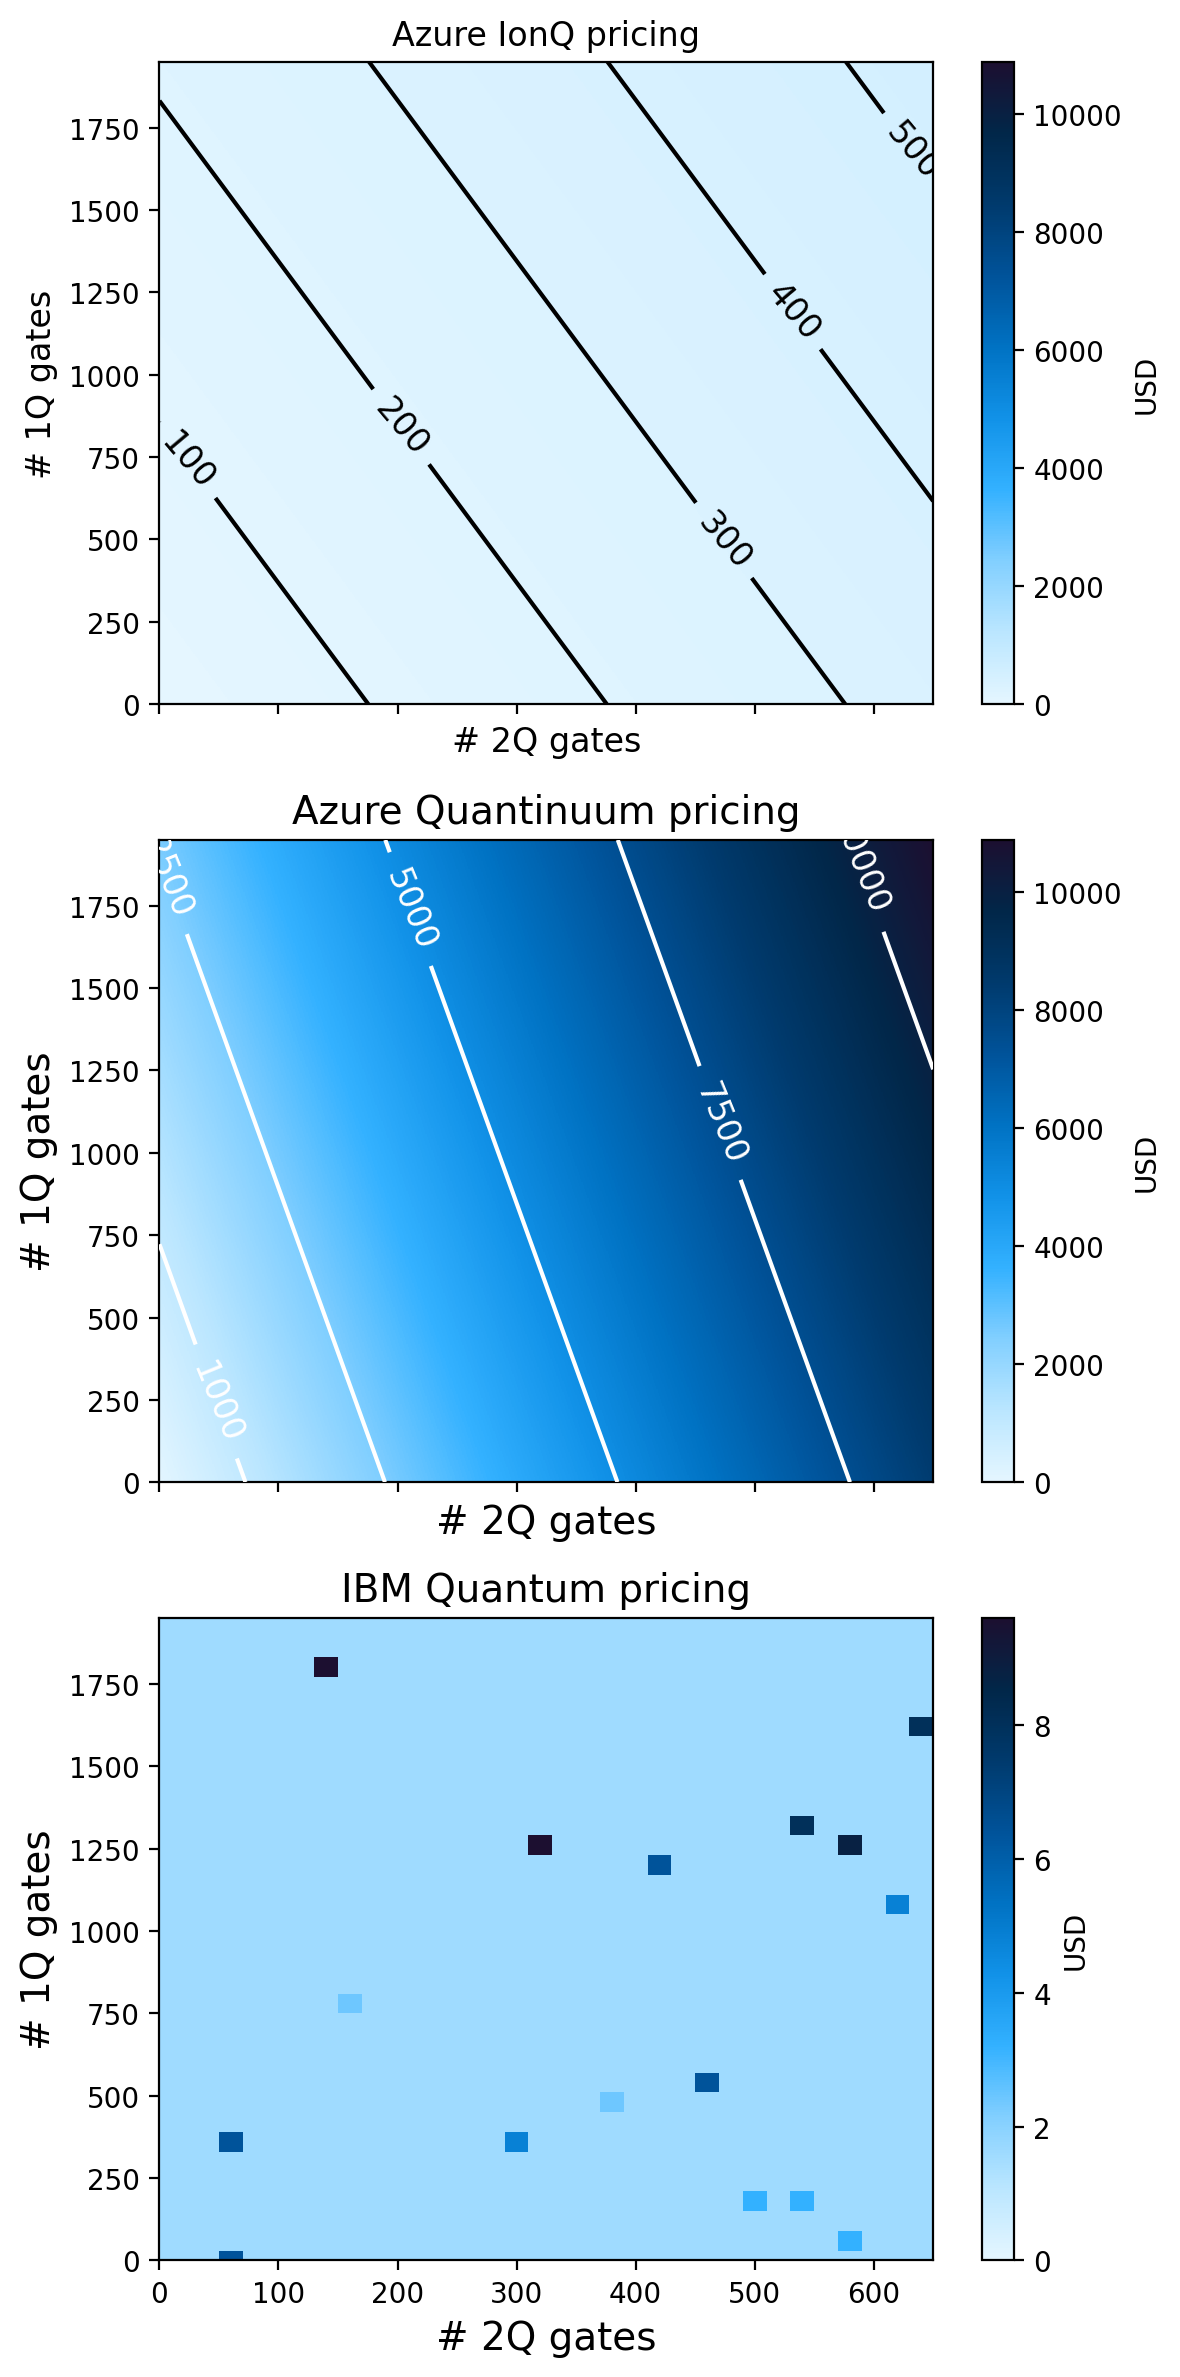

In [45]:
fig, axes = plt.subplots(3,1, figsize=(6,12), sharex=True)


res = axes[0].pcolormesh(X, Y, Z, cmap=cmap, vmin=0, vmax=Z2.max())
cont = axes[0].contour(X, Y, Z, levels=[100, 200, 300, 400, 500], zorder=3, colors='k')
plt.colorbar(res, label='USD');
axes[0].clabel(cont, cont.levels, fmt=fmt, fontsize=12)
axes[0].set_xlabel("# 2Q gates", fontsize=12)
axes[0].set_ylabel("# 1Q gates", fontsize=12)
axes[0].set_title('Azure IonQ pricing',fontsize=12)


res2 = axes[1].pcolormesh(X, Y, Z2, cmap=cmap, vmin=0, vmax=Z2.max())
cont2 = axes[1].contour(X, Y, Z2, levels=[1000, 2500, 5000, 7500, 10000], zorder=3, colors='w')
plt.colorbar(res2, label='USD');
axes[1].clabel(cont2, cont2.levels, fmt=fmt, fontsize=12);
axes[1].set_xlabel("# 2Q gates", fontsize=14)
axes[1].set_ylabel("# 1Q gates", fontsize=14)
axes[1].set_title('Azure Quantinuum pricing',fontsize=14);

res3 = axes[2].pcolormesh(X_steps, Y_steps, Z_steps, cmap=cmap, vmin=0, vmax=Z_steps.max())
#cont3 = axes[1,0].contour(X_steps, Y_steps, Z_steps, levels=[1.8], zorder=3, colors='w')
plt.colorbar(res3, label='USD');
#axes[1,0].clabel(cont3, cont3.levels, fmt=fmt, fontsize=10);
axes[2].set_xlim([0, 650])
axes[2].set_ylim([0, 1950])
axes[2].set_xlabel("# 2Q gates", fontsize=14)
axes[2].set_ylabel("# 1Q gates", fontsize=14)
axes[2].set_title('IBM Quantum pricing',fontsize=14);


fig.tight_layout();

In [46]:
total_ionq = 0
for ii in range(X_steps.shape[0]):
    for jj in range(X_steps.shape[1]):
        total_ionq += 12.42+0.000975*(X_steps[ii][jj]*512)+0.00020*(Y_steps[ii][jj]*512)

In [47]:
total_ionq

321982.99199999985

In [53]:
total_quantinuum = 0
for ii in range(X_steps.shape[0]):
    for jj in range(X_steps.shape[1]):
        total_quantinuum += 12.50*(5+(10*X_steps[ii][jj]+Y_steps[ii][jj]+ 10)*512/5000)

In [54]:
total_quantinuum

6434874.000000005

In [55]:
total_ibm = 0.8*(40*60+18)

In [56]:
total_ibm

1934.4

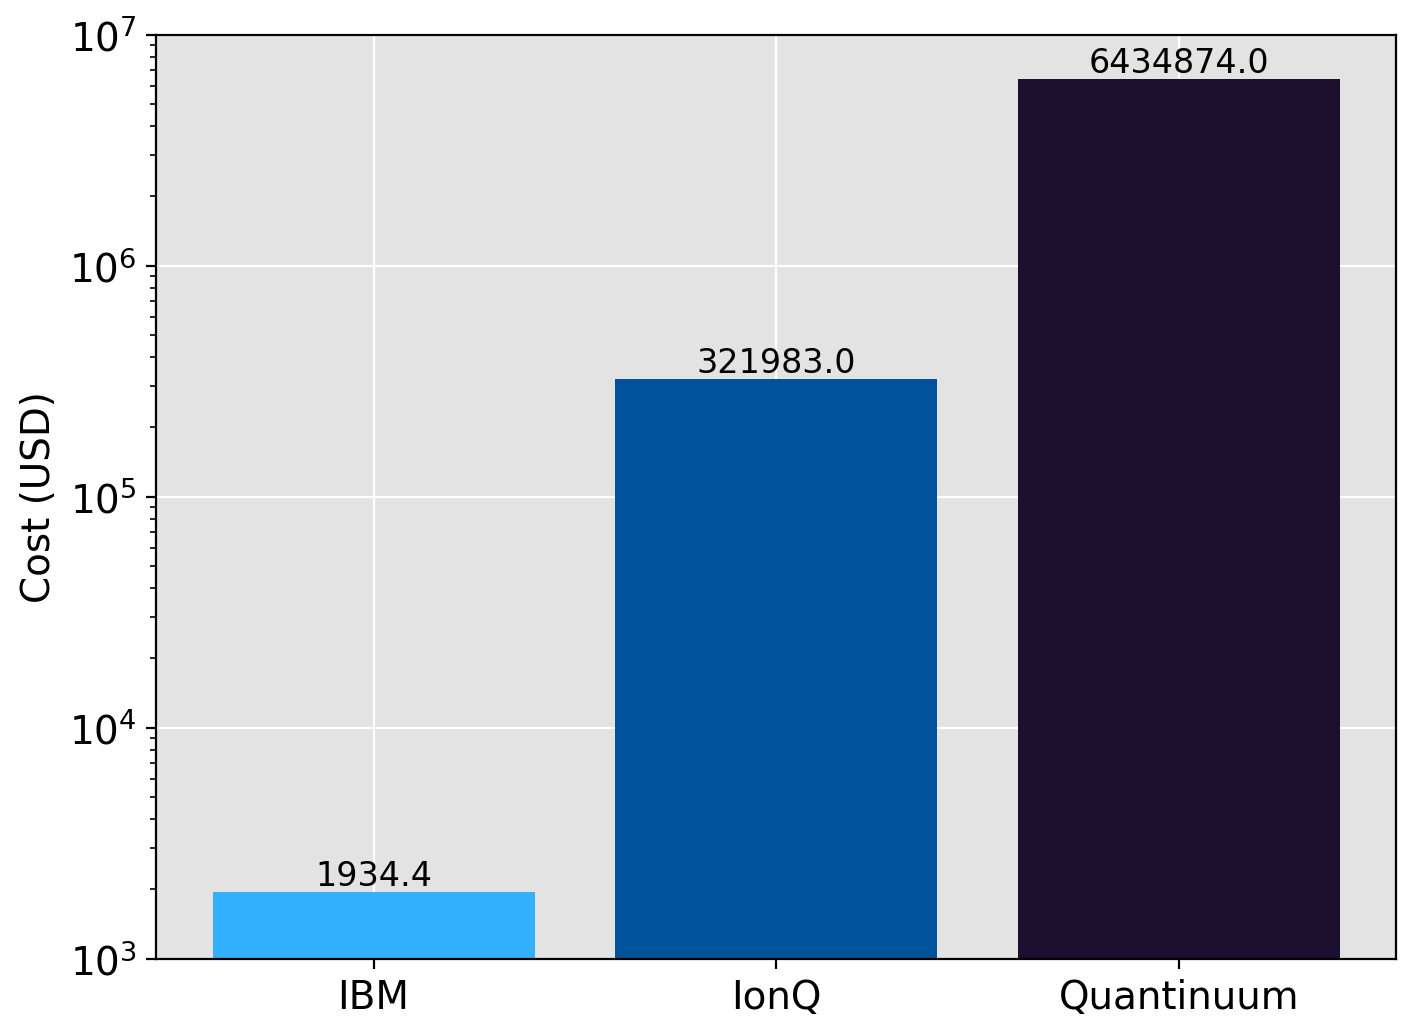

In [227]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_facecolor('#e3e3e3')
ax.grid(color='w')
ax.bar([0,1,2], [total_ibm, total_ionq, total_quantinuum], log=True, color=["#33b1ff", "#00539a", "#1c0f30"], zorder=2)
ax.set_ylabel("Cost (USD)", fontsize=14)
plt.yticks(fontsize=14)
ax.set_ylim([1e3,1e7])
ax.set_xticks([0,1,2], ['IBM', 'IonQ', 'Quantinuum'], fontsize=14)
ax.text(0, total_ibm, total_ibm, fontsize=12, ha='center', va='bottom')
ax.text(1, total_ionq, round(total_ionq,1), fontsize=12, ha='center', va='bottom')
ax.text(2, total_quantinuum, round(total_quantinuum,1), fontsize=12, ha='center', va='bottom');